In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import gridspec
from sklearn.metrics import matthews_corrcoef, roc_auc_score, accuracy_score

from src.downstream.utils import multioutput_mcc

In [2]:
MODELS = ["esm_t6", "esm_t12", "esm_t30", "esm_t33", "esm_t36", "ankh-base", "ankh-large", "prostt5", "prott5", "ohe"]
ALGOS = ["lr", "rf", "knn"]
LAYERS = {
    "esm_t6": 6,
    "esm_t12": 12,
    "esm_t30": 30,
    "esm_t33": 33,
    "esm_t36": 36,
    "ankh-base": 48,
    "ankh-large": 48,
    "prostt5": 24,
    "prott5": 24,
    "ohe": 0,
}
# 270 model layers x 3 datasets = 810 ID computations

LINES = {
    "lr": "-",
    "knn": "--",
    "rf": "dotted",
}
MODEL_COLORS = {
    "esm_t6": "lightsteelblue",
    "esm_t12": "cornflowerblue",
    "esm_t30": "royalblue",
    "esm_t33": "mediumblue",
    "esm_t36": "darkblue",
    "ankh-base": "lime",
    "ankh-large": "darkgreen",
    "prostt5": "orangered",
    "prott5": "darkorange",
    "ohe": "gray",
}

CLASS_METRIC = "ACC"
ROOT = Path("/") / "scratch" / "SCRATCH_SAS" / "roman" / "SMTB" / "embeddings"
RELATIVE = True

Path("figures").mkdir(exist_ok=True)

In [3]:
def compute_metric(root: Path, model, dataset, layer, algo, metric, level, k=4):
    with open(root / model / dataset / f"layer_{layer}" / f"predictions_{algo}_{level}_{k}.pkl", "rb") as f:
        y_hat, y = pd.read_pickle(f)[0]
    match metric.lower():
        case "mcc":
            try:
                return matthews_corrcoef(y, y_hat)
            except ValueError:
                return multioutput_mcc(y, y_hat)
        case "auroc":
            return roc_auc_score(y, y_hat)
        case "acc":
            return accuracy_score(y, y_hat)
        case _:
            raise ValueError(f"Unknown metric: {metric}")

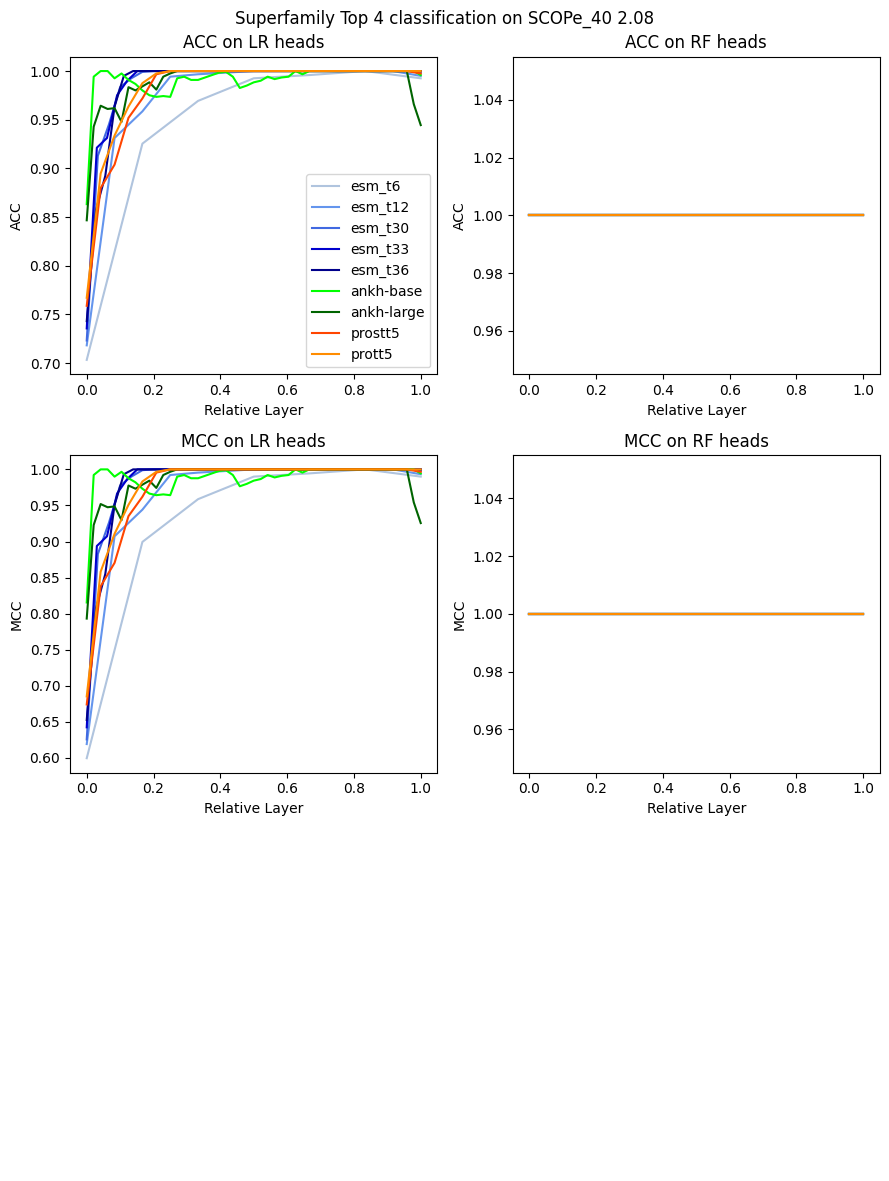

In [4]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
    [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])],
]

for j, metric in enumerate(["ACC", "MCC"]):
    for i, algorithm in enumerate(ALGOS[:-1]):
        for model in MODELS[:-1]:
            perfs = []
            for layer in range(LAYERS[model] + 1):
                result = compute_metric(ROOT, model, "scope_40_208", layer, algorithm, metric, "superfamily")
                perfs.append(result)
            if RELATIVE:
                axs[j][i].plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model, color=MODEL_COLORS[model])
            else:
                axs[j][i].plot(perfs, label=model)

        axs[j][i].set_xlabel(("Relative" if RELATIVE else "Absolute") + " Layer")
        axs[j][i].set_ylabel(metric.upper())
        axs[j][i].set_title(f"{metric.upper()} on {algorithm.upper()} heads")
        if j + i == 0:
            axs[j][i].legend()

axs[2][0].set_axis_off()
axs[2][1].set_axis_off()

plt.suptitle("Superfamily Top 4 classification on SCOPe_40 2.08")
plt.tight_layout()
plt.savefig("figures/page8.pdf", dpi=300)
plt.show()

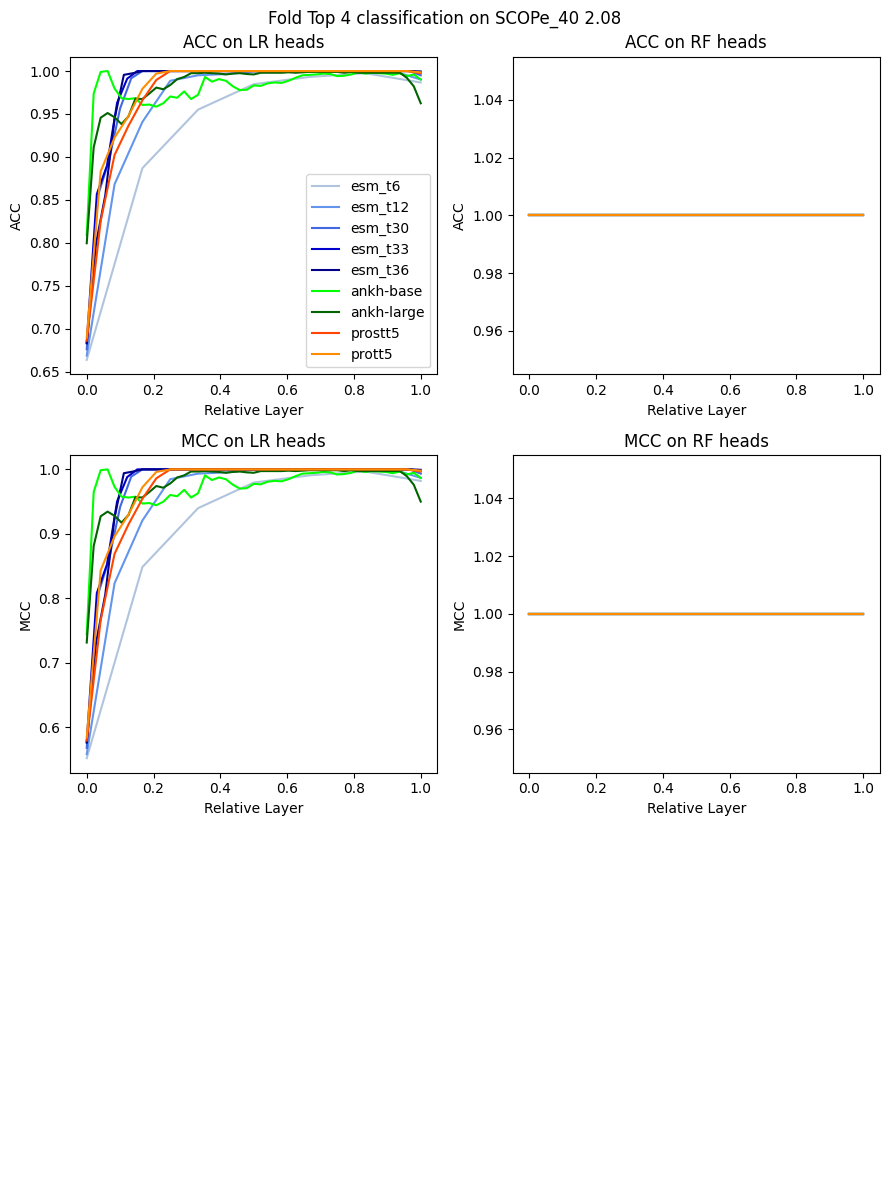

In [5]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
    [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])],
]

for j, metric in enumerate(["ACC", "MCC"]):
    for i, algorithm in enumerate(ALGOS[:-1]):
        for model in MODELS[:-1]:
            perfs = []
            for layer in range(LAYERS[model] + 1):
                result = compute_metric(ROOT, model, "scope_40_208", layer, algorithm, metric, "fold")
                perfs.append(result)
            if RELATIVE:
                axs[j][i].plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=model, color=MODEL_COLORS[model])
            else:
                axs[j][i].plot(perfs, label=model)

        axs[j][i].set_xlabel(("Relative" if RELATIVE else "Absolute") + " Layer")
        axs[j][i].set_ylabel(metric.upper())
        axs[j][i].set_title(f"{metric.upper()} on {algorithm.upper()} heads")
        if j + i == 0:
            axs[j][i].legend()

axs[2][0].set_axis_off()
axs[2][1].set_axis_off()

plt.suptitle("Fold Top 4 classification on SCOPe_40 2.08")
plt.tight_layout()
plt.savefig("figures/page9.pdf", dpi=300)
plt.show()

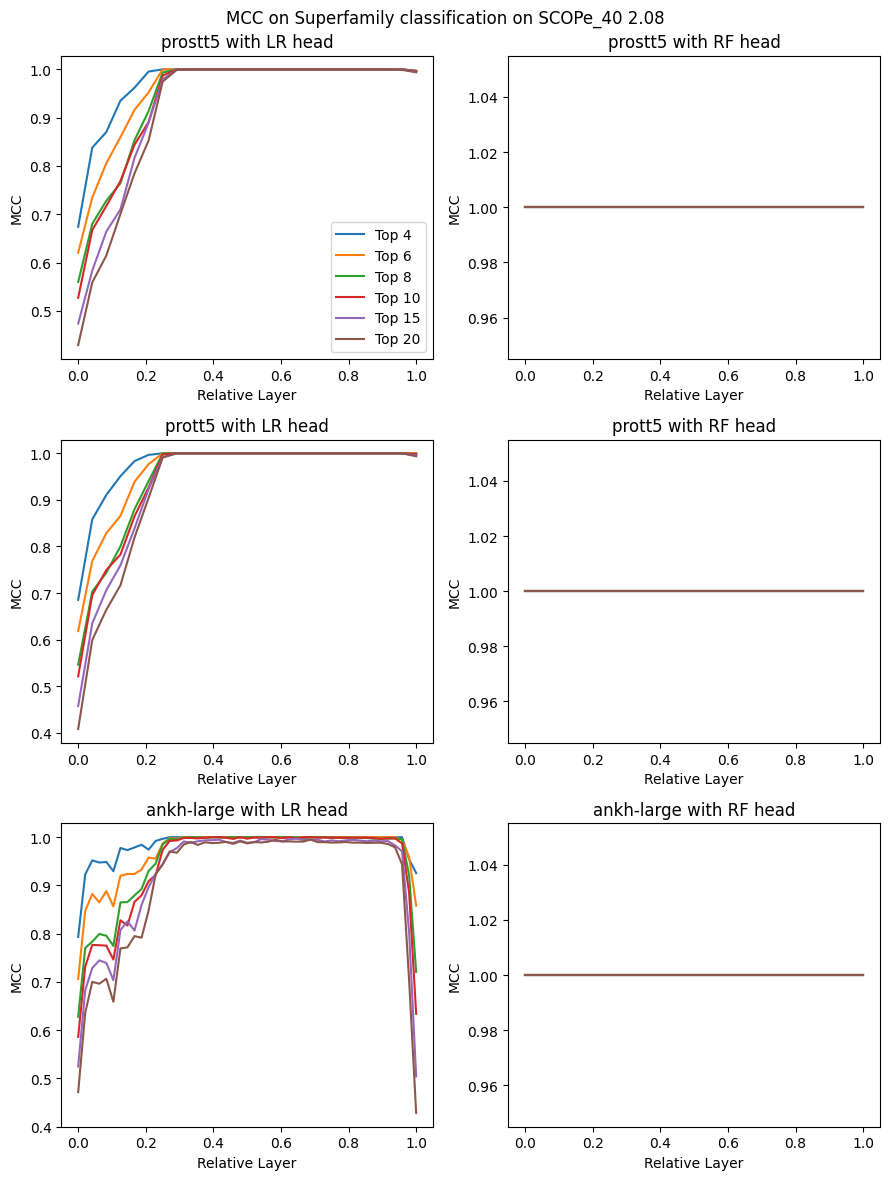

In [6]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3, 2, figure=fig)
axs = [
    [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
    [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])],
]

for j, model in enumerate(["prostt5", "prott5", "ankh-large"]):
    for i, algorithm in enumerate(["lr", "rf"]):
        for num_classes in [4, 6, 8, 10, 15, 20]:
            perfs = []
            for layer in range(LAYERS[model] + 1):
                result = compute_metric(ROOT, model, "scope_40_208", layer, algorithm, "MCC", "superfamily", k=num_classes)
                perfs.append(result)
            if RELATIVE:
                axs[j][i].plot(np.arange(0, 1 + 1e-5, 1 / (LAYERS[model])), perfs, label=f"Top {num_classes}")
            else:
                axs[j][i].plot(perfs, label=model)

            axs[j][i].set_xlabel(("Relative" if RELATIVE else "Absolute") + " Layer")
            axs[j][i].set_ylabel("MCC")
            axs[j][i].set_title(f"{model} with {algorithm.upper()} head")
            if j + i == 0:
                axs[j][i].legend()

plt.suptitle("MCC on Superfamily classification on SCOPe_40 2.08")
plt.tight_layout()
plt.savefig("figures/page10.pdf", dpi=300)
plt.show()